In [ ]:
import os

os.chdir("../")

In [ ]:
from genki_signals.signal_sources import MicSignalSource, KeyboardSignalSource, Sampler
from genki_signals.signal_functions import FourierTransform
from genki_signals.signal_system import SignalSystem


fourier_window_size = 1024
fourier_window_overlap = 512

mic_source = MicSignalSource(256)

mic_system = SignalSystem(mic_source, [FourierTransform("audio", "fourier", window_size=fourier_window_size, window_overlap=fourier_window_overlap)], 100)

In [ ]:
import pynput
from pynput.keyboard import Key

record_key = "Key.cmd"
exit_key = "Key.esc"

sample_counter = 1
recording = False

def on_press(key):
    global sample_counter, recording
    key_string = str(key)
    if key_string == record_key and not recording:
        recording = True
        mic_system.start()
        mic_system.start_recording(path="data/mic_data/sample_"+str(sample_counter))
        sample_counter += 1
    if key_string == exit_key:
        listener.stop()

def on_release(key):
    global recording
    if str(key) == record_key:
        mic_system.stop()
        recording = False

with pynput.keyboard.Listener(on_press=on_press, on_release=on_release) as listener:
    listener.join()

mic_system.stop()



In [ ]:
from genki_signals.session import Session
from genki_signals.signal_functions.serialization import decode_signal_fn
import glob


def get_data_from_session(session):
    data = session.data
    
    for signal in session.metadata["signal_functions"]:
        inputs = tuple(data[name] for name in signal.input_signals)
        output = signal(*inputs)
        data[signal.name] = output

    return data

def get_all_data(folder):
    data = []
    for session_folder in glob.glob(folder + "/*"):
        session = Session.from_filename(session_folder)
        data.append(get_data_from_session(session))
    return data

data = get_all_data("data/mic_data/")

In [25]:
import numpy as np
import librosa

mel_spectrogram_data = []

for buffer in data:
    fourier = np.abs(buffer["fourier"])
    mel_spect = librosa.feature.melspectrogram(S=fourier, sr=48000, n_fft=1024, hop_length=512)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

    mel_spectrogram_data.append(mel_spect)


/var/folders/d1/0b_7kyfs1k96s5v_pnn229j00000gn/T/ipykernel_2122/2389785755.py:9: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  mel_spect = librosa.power_to_db(mel_spect, ref=np.max)


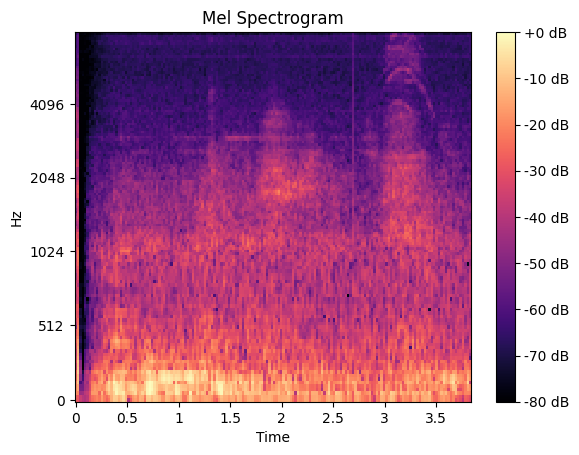

In [24]:
import librosa
import matplotlib.pyplot as plt

mel_spect = librosa.feature.melspectrogram(S=fourier_data[1], sr=48000, n_fft=1024, hop_length=512)
# print(mel_spect)
mel_spect = librosa.feature.melspectrogram(y=data[1]["audio"].astype(np.float64), sr=48000, n_fft=1024, hop_length=512)
# print(mel_spect)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')